# Surface momentum stress seasonality

Test how much the surface momentum stress varies between the continental slope and the ambient ocean (how large-scale is the signal?).

Load modules

In [15]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm                   
import cartopy.crs as ccrs                      
import matplotlib.path as mpath
import xarray.ufuncs as xu

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [16]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:35759 Dashboard: /proxy/36637/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [17]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

### Prepare data

In [18]:
lat_slice = slice(-90, -59)
start_time = '2080-01-01'
end_time   = '2089-12-31'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)

# Total ocean momentum stress at surface
tau_x = cc.querying.getvar(expt, 'tau_x', session, start_time=start_time, end_time=end_time, ncfile="ocean_month.nc")
tau_y = cc.querying.getvar(expt, 'tau_y', session, start_time=start_time, end_time=end_time, ncfile="ocean_month.nc")
tau_x = tau_x.sel(yu_ocean=lat_slice)
tau_y = tau_y.sel(yu_ocean=lat_slice)
# Ice-ocean momentum stress: strocnx_m and strocny_m (but unfortunately not available for this run)

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140407357421376 and this is thread id 140402896865024.
Exception closing connection <sqlite3.Connection object at 0x7fb2a015e210>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/

In [19]:
# Total stress
tau_t = xu.sqrt(tau_x**2 + tau_y**2)

Monthly climatology

In [20]:
#tau_x = tau_x.groupby('time.month').mean('time')
#tau_y = tau_y.groupby('time.month').mean('time')
tau_t = tau_t.groupby('time.month').mean('time')

In [21]:
#tau_x = tau_x.load()
#tau_y = tau_y.load()
tau_t = tau_t.load()

In [22]:
hu = hu.load()

### Prepare plotting

In [23]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [24]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

In [25]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [26]:
ft_size = 18
fig_path = '/g/data/x77/wgh581/Figures/'

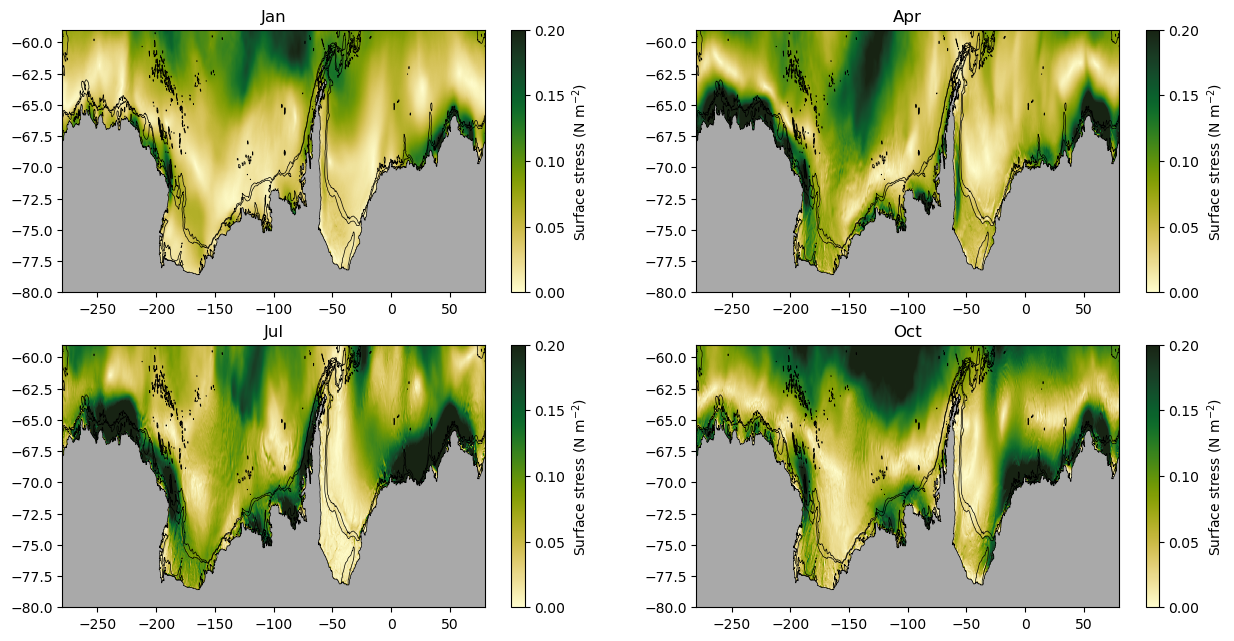

In [47]:
fig = plt.figure(figsize=(15,7.5))

for ii in range(4):
    plt.subplot(2,2,ii+1)
    plt.title(month[ii*3])
    plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey')
    plt.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5)
    plt.contour(hu.xu_ocean, hu.yu_ocean, hu, [650, 2000], linewidths=0.5, colors='k')
    sc = plt.pcolormesh(tau_t.xu_ocean, tau_t.yu_ocean, tau_t[ii*3,:,:], vmin=0, vmax=0.2, cmap=cm.cm.speed)
    cbar = plt.colorbar(sc, ticks=np.arange(0, 0.25, 0.05))
    cbar.set_label('Surface stress (N m$^{-2}$)')
    plt.ylim(-80, -59)
    
# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_surface_stress_seasonal_climatology.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')